### Imports

In [5]:
from functions.load_data import load_CIFAR_data, load_Google_Digit_Data, load_MNIST_data, shuffle_data
from functions.attacks import attackTestSet, attackTestSetBatch
from functions.models import buildReLuModel, buildTropicalModel
from custom_layers.tropLayers import BimodalBinaryInitializer, BimodalNormalInitializer, Triangular
from tensorflow.keras import losses, initializers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the CIFAR-10 dataset and preprocess the data
train_images, test_images, train_labels, test_labels = load_MNIST_data(desired_classes=[0,1,2,3,4,5,6,7,8,9])

# Normalize pixel values to be between 0 and 1
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

#print(train_images.shape, test_images.shape)
# Create a sequential model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten the output for fully connected layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # 10 classes for CIFAR-10

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_data=(test_images, test_labels))

#model.build(input_shape=(32, 28, 28, 1))
#model.summary()

Epoch 1/10
289/938 [========>.....................] - ETA: 56s - loss: 0.4246 - accuracy: 0.8716

KeyboardInterrupt: 

### Quick test to see if adding ReLU trained weights before fitting might be a good initializer: 
#### nothing major found, but could come back to this.

In [104]:
from custom_layers.tropLayers import TropEmbedMaxMin
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

pre_trained_weights1 = [model_objects[0].layers[0].get_weights()[0].T]
model = Sequential([TropEmbedMaxMin(100, x_train.shape[1], initializer_w = initializers.random_normal, lam=0.01),
                    Dense(1, activation='sigmoid',  kernel_initializer=initializers.random_normal)])
model.get_layer('trop_embed_max_min_10').set_weights(pre_trained_weights1)
model.compile(optimizer=Adam(0.1),loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, verbose=1)
model.evaluate(x_test, y_test)

plt.hist(pre_trained_weights1[0].flatten(), bins = 1000, alpha=0.2)
plt.hist(model.layers[0].get_weights()[0].flatten(), bins = 1000, alpha=0.2)
plt.show()

(307200,)

### CIFAR 2 class, accuracy look as change layer size

In [39]:
x_train, x_test, y_train, y_test = load_CIFAR_data(desired_classes=[7, 8])

for i in range(1, 200, 2):
    print(f'================\n\t{i}\n================')
    for j in range(5):
        x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
        data = []
        built_model = buildTropicalModel(x_train, y_train,  first_layer_size = i,  verbose = 1, lam=0.025)
        pre_loss, pre_acc = built_model.evaluate(x_test, y_test) 
        with open('CIFAR_layer_size_test.csv', 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([i,pre_loss, pre_acc])

	1
Epoch 1/10
313/313 [==============================] - 3s 2ms/step - loss: 0.7095 - accuracy: 0.5986
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 0.6790 - accuracy: 0.6869
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 0.6825 - accuracy: 0.7048
Epoch 4/10
313/313 [==============================] - 1s 4ms/step - loss: 0.6649 - accuracy: 0.7328
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 0.6529 - accuracy: 0.7469
Epoch 6/10
313/313 [==============================] - 1s 3ms/step - loss: 0.6510 - accuracy: 0.7447
Epoch 7/10
313/313 [==============================] - 1s 3ms/step - loss: 0.6454 - accuracy: 0.7481
Epoch 8/10
313/313 [==============================] - 1s 4ms/step - loss: 0.6310 - accuracy: 0.7494
Epoch 9/10
313/313 [==============================] - 1s 3ms/step - loss: 0.6241 - accuracy: 0.7537
Epoch 10/10
313/313 [==============================] - 1s 3ms/step - loss: 0.6546 - accuracy: 0.7

      i      loss  accuracy
0     1  0.651843  0.735833
1     3  0.814410  0.762000
2     5  1.029756  0.754000
3     7  1.079986  0.759083
4     9  1.207591  0.765333
..  ...       ...       ...
95  191  8.092161  0.632917
96  193  8.204059  0.658333
97  195  7.444806  0.787083
98  197  7.617189  0.744750
99  199  7.633082  0.789750

[100 rows x 3 columns]


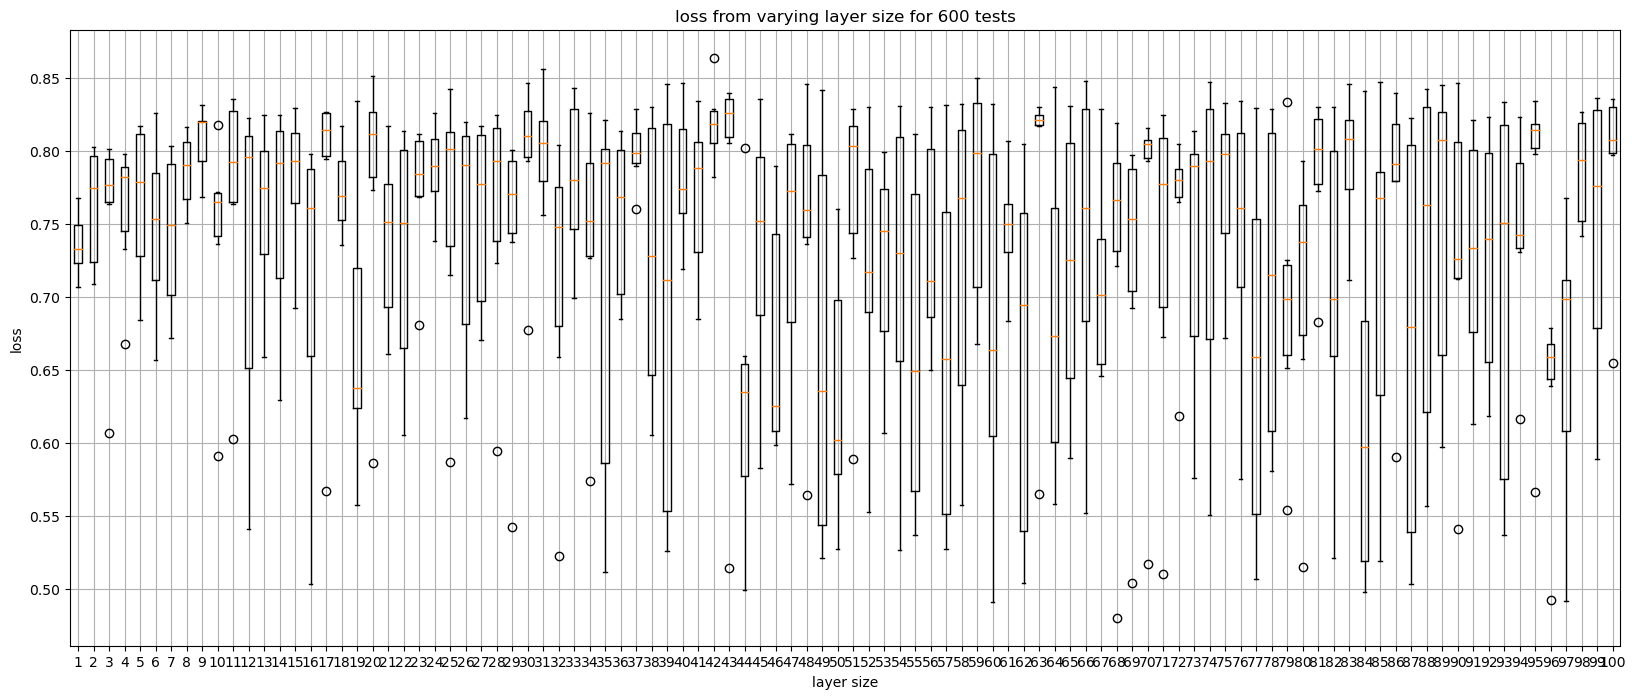

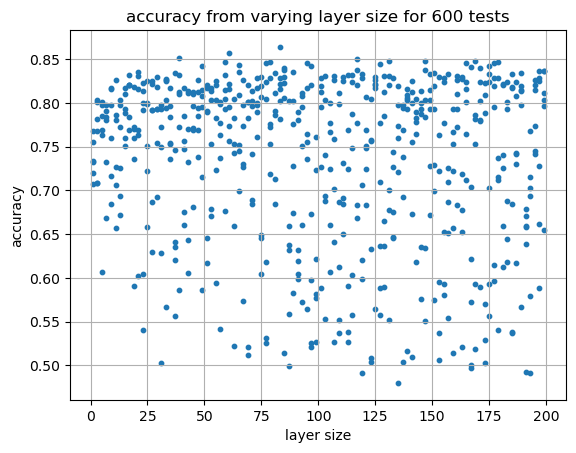

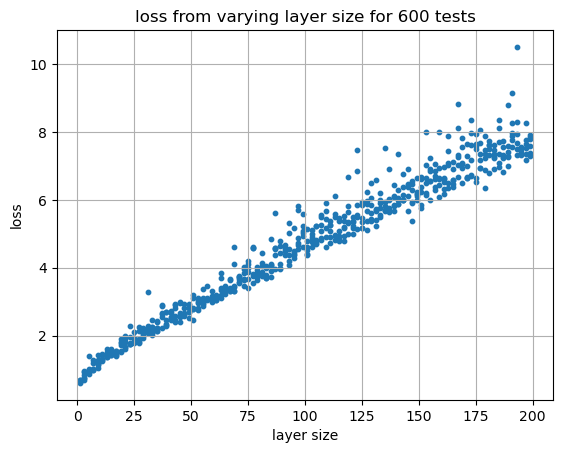

In [13]:
scat_size = 10
bin_num = 784
hist_wid = 20
hist_hei = 8
data = pd.read_csv("CIFAR_layer_size_test.csv")
rowNum = data.shape[0]
i_avg = data.groupby('i').mean().reset_index()
print(i_avg)

plt.figure(figsize=(hist_wid,hist_hei))
plt.boxplot([data['accuracy'][data['i'] == i] for i in data['i'].unique()])
plt.xlabel('layer size')
plt.ylabel('loss')
plt.title(f'loss from varying layer size for {rowNum} tests')
plt.grid(True)
plt.show() 

plt.scatter(data['i'], data['accuracy'], s=scat_size)
plt.xlabel('layer size')
plt.ylabel('accuracy')
plt.title(f'accuracy from varying layer size for {rowNum} tests')
plt.grid(True)
plt.show()

plt.scatter(data['i'], data['loss'], s=scat_size)
plt.xlabel('layer size')
plt.ylabel('loss')
plt.title(f'loss from varying layer size for {rowNum} tests')
plt.grid(True)
plt.show() 



### CIFAR 2 class test, ensembling multiple 1 layer models to test performance

In [35]:
x_train, x_test, y_train, y_test = load_CIFAR_data(desired_classes=[7, 8])
model_objects = []
for i in range(5):
    print(f'================\n\t{i}\n================')
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
    data = []
    built_model = buildTropicalModel(x_train, y_train,  first_layer_size = 20,  verbose = 1, lam=0.025)
    pre_loss, pre_acc = built_model.evaluate(x_test, y_test) 
    model_objects.append(built_model)
    with open('CIFAR_1_neuron_layer_test.csv', 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow([i,pre_loss, pre_acc])

	0
Epoch 1/10
313/313 [==============================] - 3s 6ms/step - loss: 1.3606 - accuracy: 0.7299
Epoch 2/10
313/313 [==============================] - 2s 7ms/step - loss: 1.8119 - accuracy: 0.7680
Epoch 3/10
313/313 [==============================] - 3s 9ms/step - loss: 1.9465 - accuracy: 0.7816
Epoch 4/10
313/313 [==============================] - 3s 9ms/step - loss: 2.0036 - accuracy: 0.7556
Epoch 5/10
313/313 [==============================] - 3s 10ms/step - loss: 1.9571 - accuracy: 0.7861
Epoch 6/10
313/313 [==============================] - 3s 10ms/step - loss: 1.9336 - accuracy: 0.7886
Epoch 7/10
313/313 [==============================] - 3s 10ms/step - loss: 1.9555 - accuracy: 0.7696
Epoch 8/10
313/313 [==============================] - 3s 11ms/step - loss: 1.8673 - accuracy: 0.7806
Epoch 9/10
313/313 [==============================] - 3s 10ms/step - loss: 1.7978 - accuracy: 0.7789
Epoch 10/10
313/313 [==============================] - 3s 10ms/step - loss: 1.7442 - accurac

In [36]:
x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test)
num_models = len(model_objects)

model_predictions = [model_objects[i].predict(x_test) for i in range(num_models)]
ensemble_sum = np.sum(model_predictions, axis=0)

ensemble_class_indices = np.array(ensemble_sum>(num_models/2)).astype(int).reshape(-1)
accuracy = np.mean(y_test == ensemble_class_indices)
print(f'Ensemble Accuracy: {accuracy}')

63/63 [==============================] - 0s 5ms/step
Ensemble Accuracy: 0.8255


In [38]:
np.array(model_predictions[0]>0.5).astype(int)


array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

### CIFAR 2 class, PGD attack, different Initializer test

In [2]:
loss_object = losses.BinaryCrossentropy()
x_train, x_test, y_train, y_test = load_CIFAR_data(desired_classes=[7, 8])
tests = [0,0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
for i in tests:
    print(f'================\n\t{i}\n================')
    data = []
    built_model = buildTropicalModel(x_train, y_train, num_epochs = 10, first_layer_size = 100, initializer_w=initializers.RandomNormal(mean=0.5, stddev=0.005, seed=0), verbose = 1,
                        second_layer_size = 1,second_layer_activation = 'sigmoid', training_loss = 'binary_crossentropy', lam=i)
    x_test_att = attackTestSetBatch(built_model, x_test, y_test, loss_object, str(i))
    pre_loss, pre_acc = built_model.evaluate(x_test, y_test)
    post_loss, post_acc = built_model.evaluate(x_test_att, y_test)
    data = [i,pre_loss, pre_acc, post_loss, post_acc]
    with open('CIFAR_lambda_test2.csv', 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

	0.0
Epoch 1/25
313/313 [==============================] - 13s 31ms/step - loss: 0.6399 - accuracy: 0.7642
Epoch 2/25
313/313 [==============================] - 9s 30ms/step - loss: 0.5618 - accuracy: 0.7949
Epoch 3/25
313/313 [==============================] - 9s 29ms/step - loss: 0.6076 - accuracy: 0.7968
Epoch 4/25
313/313 [==============================] - 9s 29ms/step - loss: 0.5481 - accuracy: 0.8084
Epoch 5/25
313/313 [==============================] - 9s 30ms/step - loss: 0.5164 - accuracy: 0.8173
Epoch 6/25
313/313 [==============================] - 9s 30ms/step - loss: 0.5204 - accuracy: 0.8183
Epoch 7/25
313/313 [==============================] - 9s 30ms/step - loss: 0.6643 - accuracy: 0.7859
Epoch 8/25
313/313 [==============================] - 9s 30ms/step - loss: 0.6510 - accuracy: 0.7909
Epoch 9/25
313/313 [==============================] - 9s 30ms/step - loss: 0.8052 - accuracy: 0.7687
Epoch 10/25
313/313 [==============================] - 10s 31ms/step - loss: 0.5500 -

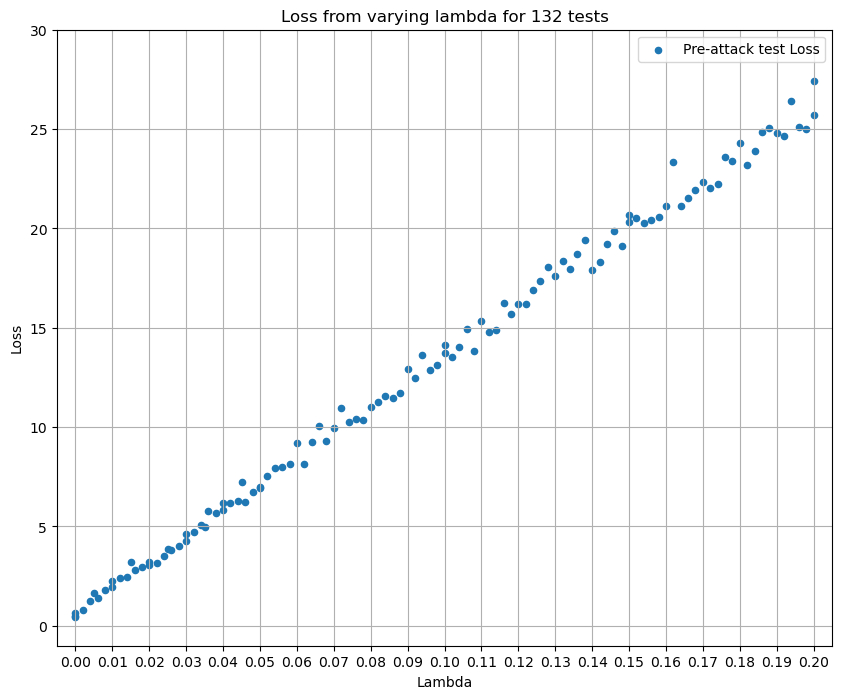

"\nplt.figure(figsize=(hist_wid,hist_hei))\nfor i in model_objects:\n    plt.hist(i.layers[0].get_weights()[0].flatten(), bins=bin_num, alpha=0.3, label='l')\nplt.xlabel('Initial Accuracy on Test Set')\nplt.ylabel('Count')\nplt.title(f'Initial Accuracy for {rowNum} tests')\nplt.ylim(0, 7000)\n#plt.legend()\nplt.show()\n"

In [14]:
scat_size = 20
bin_num = 784
hist_wid = 10
hist_hei = 8
data = pd.read_csv("CIFAR_lambda_test.csv")
rowNum = data.shape[0]

#lambda,pre_loss,pre_acc,post_loss,post_acc

data["loss_diff"] = data['post_loss'] - data['pre_loss']
data["acc_diff"] = data['post_acc'] - data['pre_acc']

columns = ["pre_loss"]#, "post_loss"]
settings = ["Pre-attack test Loss", "Post-attack test Loss"]

plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.scatter(data['lambda'], data[columns[i]], label=settings[i], s=scat_size)
plt.xticks([i/100 for i in range(101)])
#plt.yticks([i/20 for i in range(21)])
plt.xlabel('Lambda')
plt.xlim(-0.005, 0.205)
plt.ylim(-1, 30)
plt.ylabel('Loss')
plt.title(f'Loss from varying lambda for {rowNum} tests')
plt.grid(True)
plt.legend()
plt.show()

'''
plt.figure(figsize=(hist_wid,hist_hei))
for i in model_objects:
    plt.hist(i.layers[0].get_weights()[0].flatten(), bins=bin_num, alpha=0.3, label='l')
plt.xlabel('Initial Accuracy on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Accuracy for {rowNum} tests')
plt.ylim(0, 7000)
#plt.legend()
plt.show()
'''

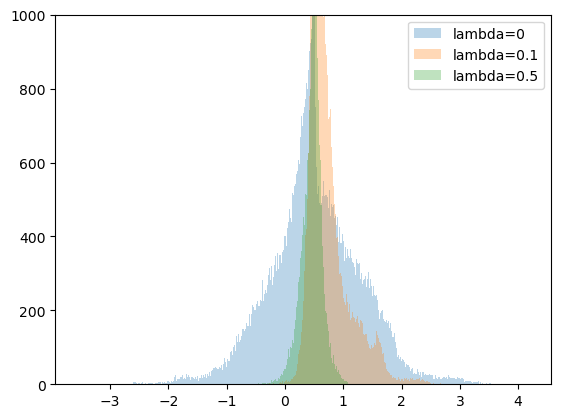

In [10]:
'''
x_train, x_test, y_train, y_test = load_CIFAR_data(desired_classes=[7, 8])
t_model1 = buildTropicalModel(x_train, y_train, verbose=1, initializer_w=BimodalNormalInitializer(stddev=1,high=5.5, low=-4.5), lam = 0)
weights1 = t_model1.layers[0].get_weights()[0].flatten()

t_model2 = buildTropicalModel(x_train, y_train,  verbose=1,initializer_w=BimodalNormalInitializer(stddev=1,high=5.5, low=-4.5), lam = 0.1)
weights2 = t_model2.layers[0].get_weights()[0].flatten()

t_model3 = buildTropicalModel(x_train, y_train, verbose=1, initializer_w=BimodalNormalInitializer(stddev=1,high=5.5, low=-4.5), lam = 0.5)
weights3 = t_model3.layers[0].get_weights()[0].flatten()

x_train, x_test, y_train, y_test = load_CIFAR_data(desired_classes=[7, 8])
t_model1 = buildTropicalModel(x_train, y_train, verbose=1, initializer_w=initializers.RandomNormal(0.5, 0.005, seed=0), lam = 0)
weights1 = t_model1.layers[0].get_weights()[0].flatten()

t_model2 = buildTropicalModel(x_train, y_train,  verbose=1,initializer_w=initializers.RandomNormal(0.5, 0.005, seed=0), lam = 0.1)
weights2 = t_model2.layers[0].get_weights()[0].flatten()

t_model3 = buildTropicalModel(x_train, y_train, verbose=1, initializer_w=initializers.RandomNormal(0.5, 0.005, seed=0), lam = 0.5)
weights3 = t_model3.layers[0].get_weights()[0].flatten()

t_model1.evaluate(x_test, y_test)
t_model2.evaluate(x_test, y_test)
t_model3.evaluate(x_test, y_test)
'''
plt.hist(weights1, bins = 784, alpha = 0.3, label='lambda=0')
plt.hist(weights2, bins = 784, alpha = 0.3, label='lambda=0.1')
plt.hist(weights3, bins = 784, alpha = 0.3, label='lambda=0.5')
plt.ylim(0,1000)
plt.legend()
plt.show()


### Initializers Tests

In [15]:
iterations = 100
loss_object = losses.BinaryCrossentropy()
x_train, x_test, y_train, y_test = load_CIFAR_data()
tests = [(buildReLuModel, initializers.RandomNormal(mean=0.5, stddev=1., seed=0), "ReLU"),
         (buildTropicalModel, BimodalBinaryInitializer(high=5.5, low=-4.5), "Tropical -4.5 or 5.5"),
         (buildTropicalModel, BimodalNormalInitializer(stddev=1,high=5.5, low=-4.5), "Tropical ~N(-4.5,1) or ~N(5.5,1)"),
         (buildTropicalModel, Triangular(left=0,mode=0.5, right=1), "Tropical ~Triangular(0, 0.5, 1)"),
         (buildTropicalModel, initializers.Constant(0.5), "Tropical vector of all 0.5"),
         (buildTropicalModel, initializers.RandomNormal(0.5, 0.005, seed=0), "Tropical ~N(0.5,0.005)"),
         (buildTropicalModel, initializers.random_normal, "Tropical random_normal")]

for i in range(iterations):
    print(f'================\n\t{i}\n================')
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test) 
    data = []
    for model, intializer_w, name in tests:
        built_model = model(x_train, y_train, initializer_w=intializer_w, verbose = 1)
        x_test_att = attackTestSetBatch(built_model, x_test, y_test, loss_object, name)
        pre_loss, pre_acc = built_model.evaluate(x_test, y_test)
        post_loss, post_acc = built_model.evaluate(x_test_att, y_test)
        data.extend([pre_loss, pre_acc, post_loss, post_acc])
    with open('Initializer_Test.csv', 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)


"\nfor i in range(iterations):\n    print(f'================\n\t{i}\n================')\n    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test) \n    data = []\n    for model, intializer_w, name in tests:\n        built_model = model(x_train, y_train, initializer_w=intializer_w, verbose = 1)\n        x_test_att = attackTestSetBatch(built_model, x_test, y_test, loss_object, name)\n        pre_loss, pre_acc = built_model.evaluate(x_test, y_test)\n        post_loss, post_acc = built_model.evaluate(x_test_att, y_test)\n        data.extend([pre_loss, pre_acc, post_loss, post_acc])\n    with open('Initializer_Test.csv', 'a', newline='') as csvfile:\n        csvwriter = csv.writer(csvfile)\n        csvwriter.writerow(data)\n"

In [55]:
names = ['relu', 'trop_bin', 'trop_nor', 'trop_tri', 'trop_constant', 'trop_rand_small', 'trop_rand_default']
types = ['_pre_loss', '_pre_acc', '_post_loss', '_post_acc', '_loss_diff', '_acc_diff']
col_headers = [i+j for i in names for j in types]
pre_loss_headers = [i for i in col_headers if types[0] in i]
pre_acc_headers = [i for i in col_headers if types[1] in i]
post_loss_headers = [i for i in col_headers if types[2] in i]
post_acc_headers = [i for i in col_headers if types[3] in i]
loss_diff_headers = [i for i in col_headers if types[4] in i]
acc_diff_headers = [i for i in col_headers if types[5] in i]
settings = [tup[2] for tup in tests]

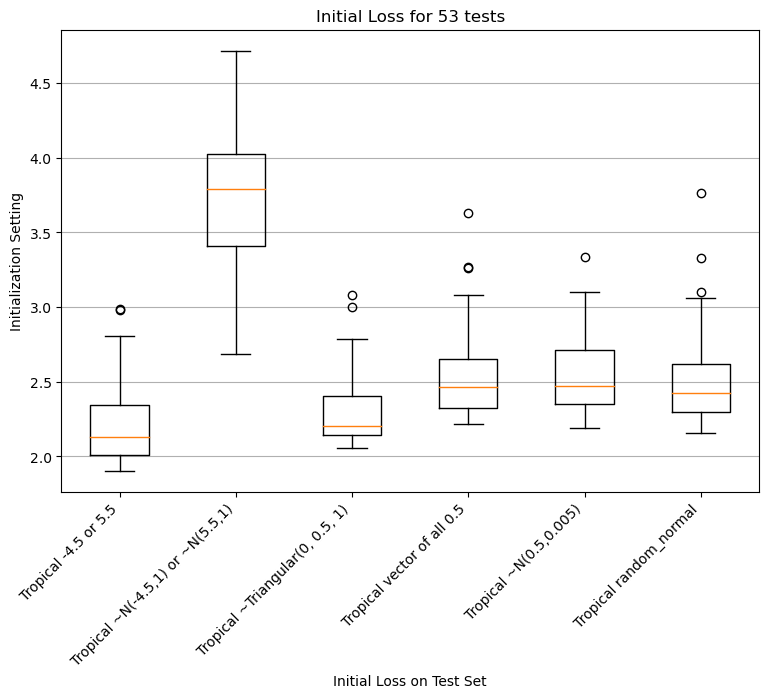

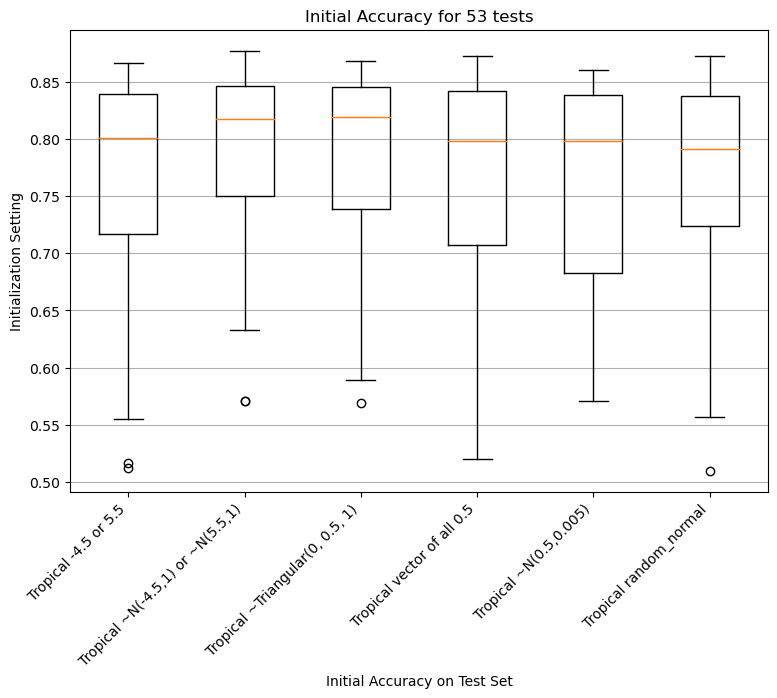

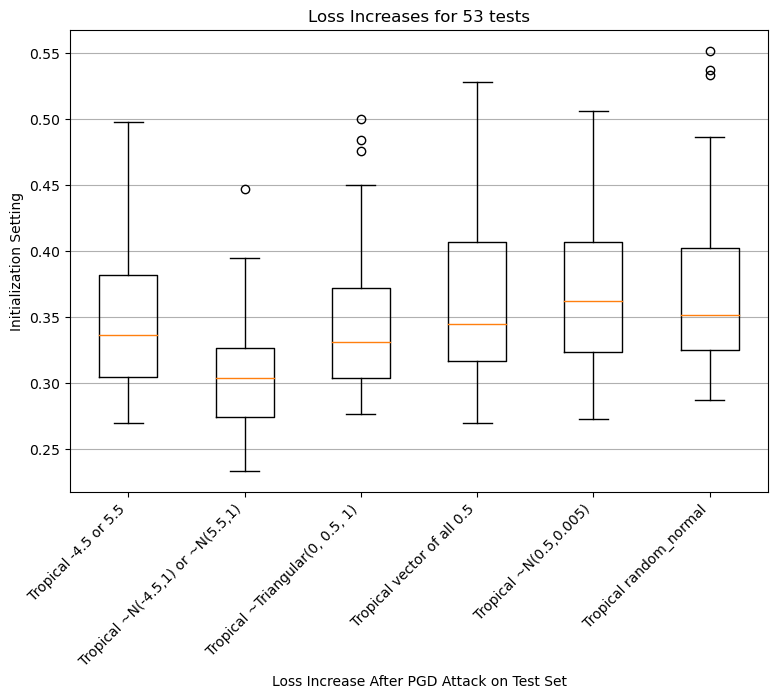

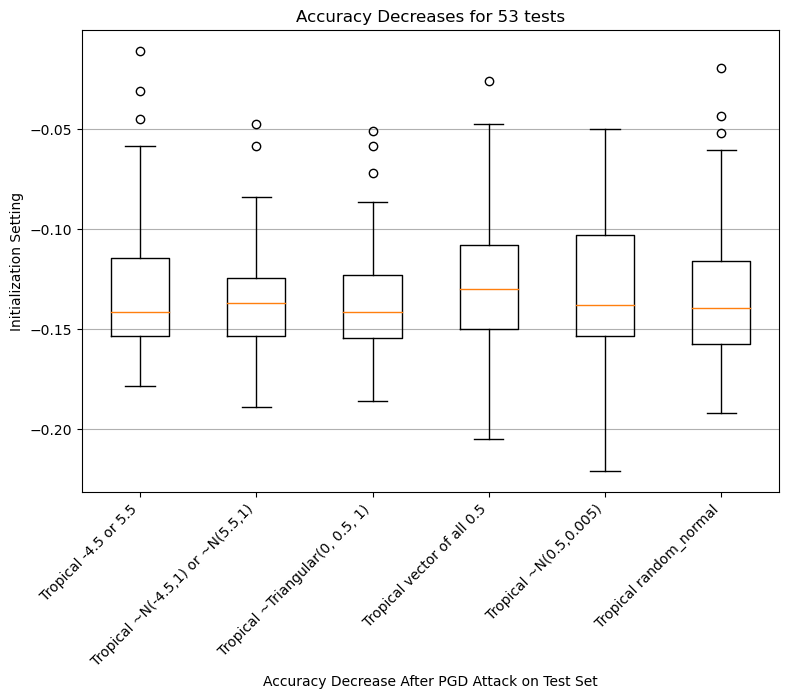

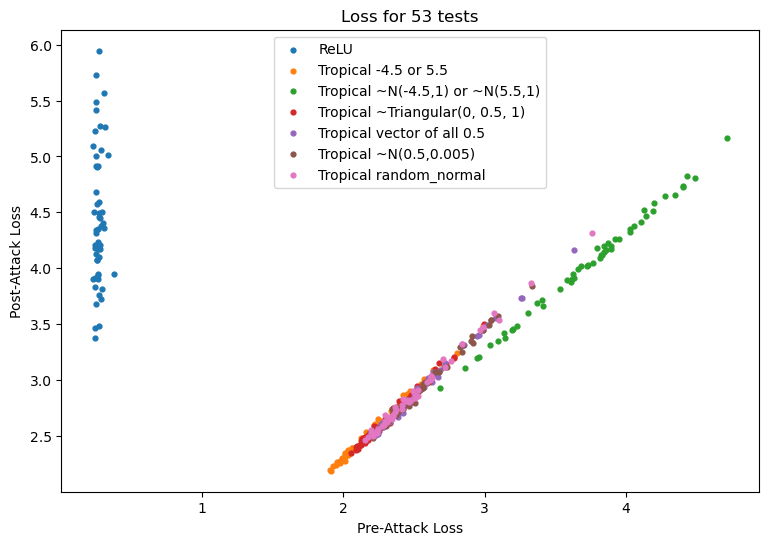

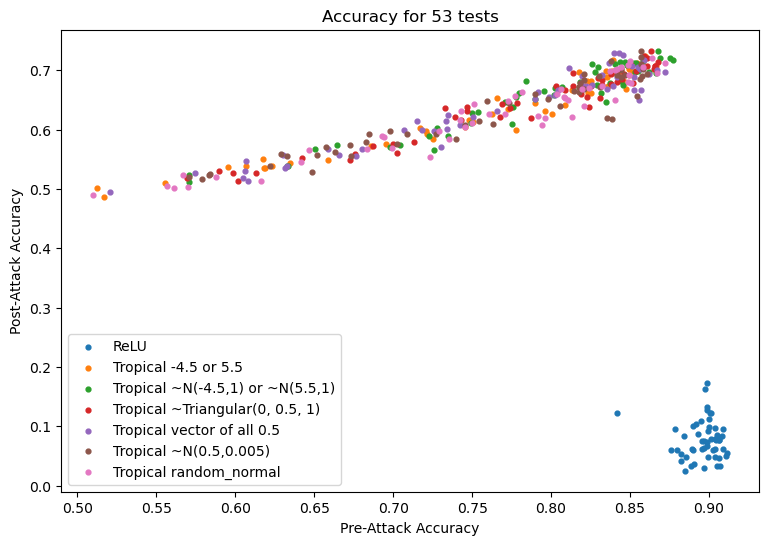

In [67]:
scat_size = 12
bin_num = 40
hist_wid = 9
hist_hei = 6
round_dec = 4
data = pd.read_csv("Initializer_Test.csv")
rowNum = data.shape[0]

for i in range(len(settings)):
    data[loss_diff_headers[i]] = data[post_loss_headers[i]] - data[pre_loss_headers[i]]
    data[acc_diff_headers[i]] = data[post_acc_headers[i]] - data[pre_acc_headers[i]]

plt.figure(figsize=(hist_wid,hist_hei))
plt.boxplot(data[pre_loss_headers[1:]], labels=settings[1:])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Initialization Setting')
plt.xlabel('Initial Loss on Test Set')
plt.title(f'Initial Loss for {rowNum} tests')
plt.grid(axis = 'y')
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.boxplot(data[pre_acc_headers[1:]], labels=settings[1:])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Initialization Setting')
plt.xlabel('Initial Accuracy on Test Set')
plt.title(f'Initial Accuracy for {rowNum} tests')
plt.grid(axis = 'y')
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.boxplot(data[loss_diff_headers[1:]], labels=settings[1:])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Initialization Setting')
plt.xlabel('Loss Increase After PGD Attack on Test Set')
plt.title(f'Loss Increases for {rowNum} tests')
plt.grid(axis = 'y')
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.boxplot(data[acc_diff_headers[1:]], labels=settings[1:])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Initialization Setting')
plt.xlabel('Accuracy Decrease After PGD Attack on Test Set')
plt.title(f'Accuracy Decreases for {rowNum} tests')
plt.grid(axis = 'y')
plt.show()

columns1 = pre_loss_headers
columns2 = post_loss_headers
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.scatter(data[columns1[i]], data[columns2[i]], s=scat_size, label=settings[i])
plt.xlabel('Pre-Attack Loss')
plt.ylabel('Post-Attack Loss')
plt.title(f'Loss for {rowNum} tests')
plt.legend()
plt.show()

columns1 = pre_acc_headers
columns2 = post_acc_headers
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.scatter(data[columns1[i]], data[columns2[i]], s=scat_size, label=settings[i])
plt.xlabel('Pre-Attack Accuracy')
plt.ylabel('Post-Attack Accuracy')
plt.title(f'Accuracy for {rowNum} tests')
plt.legend()
plt.show()


In [32]:
x_train, x_test, y_train, y_test = load_CIFAR_data()
tests = [(buildReLuModel, initializers.RandomNormal(mean=0.5, stddev=1., seed=0), "ReLU"),
         (buildTropicalModel, BimodalBinaryInitializer(high=5.5, low=-4.5), "Tropical -4.5 or 5.5"),
         (buildTropicalModel, BimodalNormalInitializer(stddev=1,high=5.5, low=-4.5), "Tropical ~N(-4.5,1) or ~N(5.5,1)"),
         (buildTropicalModel, Triangular(left=0,mode=0.5, right=1), "Tropical ~Triangular(0, 0.5, 1)"),
         (buildTropicalModel, initializers.Constant(0.5), "Tropical vector of all 0.5"),
         (buildTropicalModel, initializers.RandomNormal(0.5, 0.005, seed=0), "Tropical ~N(0.5,0.005)"),
         (buildTropicalModel, initializers.random_normal, "Tropical random_normal")]

model_objects = []
for model, intializer_w, name in tests:
    built_model = model(x_train, y_train, initializer_w=intializer_w, verbose = 1)
    model_objects.append(built_model)


Epoch 1/10
313/313 [==============================] - 2s 2ms/step - loss: 344.7119 - accuracy: 0.7928
Epoch 2/10
313/313 [==============================] - 1s 2ms/step - loss: 52.8669 - accuracy: 0.8295
Epoch 3/10
313/313 [==============================] - 1s 2ms/step - loss: 8.5932 - accuracy: 0.8464
Epoch 4/10
313/313 [==============================] - 1s 2ms/step - loss: 1.6604 - accuracy: 0.8619
Epoch 5/10
313/313 [==============================] - 1s 2ms/step - loss: 0.4541 - accuracy: 0.8806
Epoch 6/10
313/313 [==============================] - 1s 2ms/step - loss: 0.2433 - accuracy: 0.9066
Epoch 7/10
313/313 [==============================] - 1s 2ms/step - loss: 0.2254 - accuracy: 0.9093
Epoch 8/10
313/313 [==============================] - 1s 2ms/step - loss: 0.2242 - accuracy: 0.9111
Epoch 9/10
313/313 [==============================] - 1s 3ms/step - loss: 0.2209 - accuracy: 0.9132
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.2283 - accuracy: 0.9

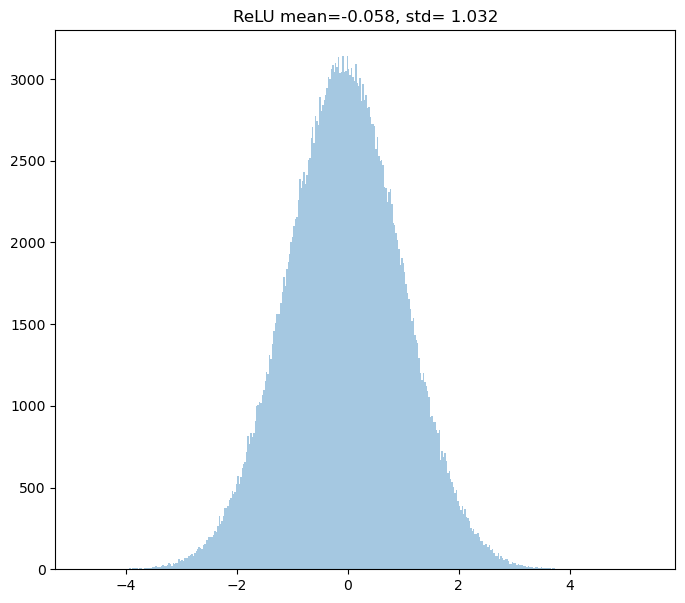

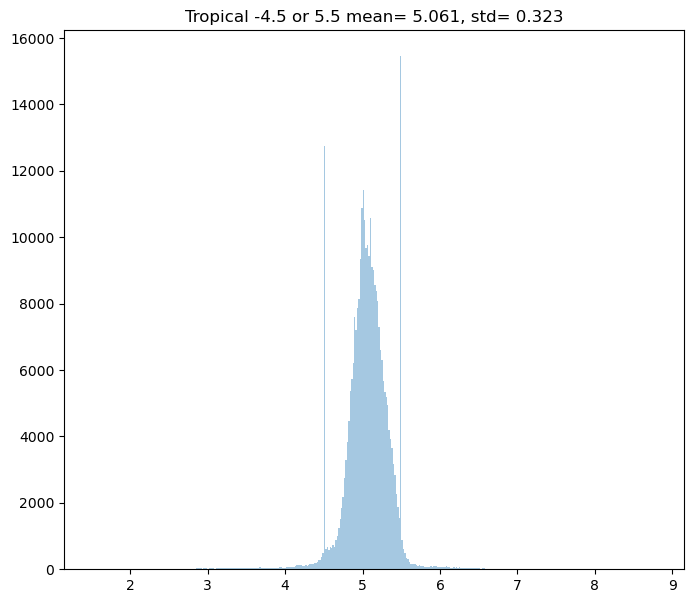

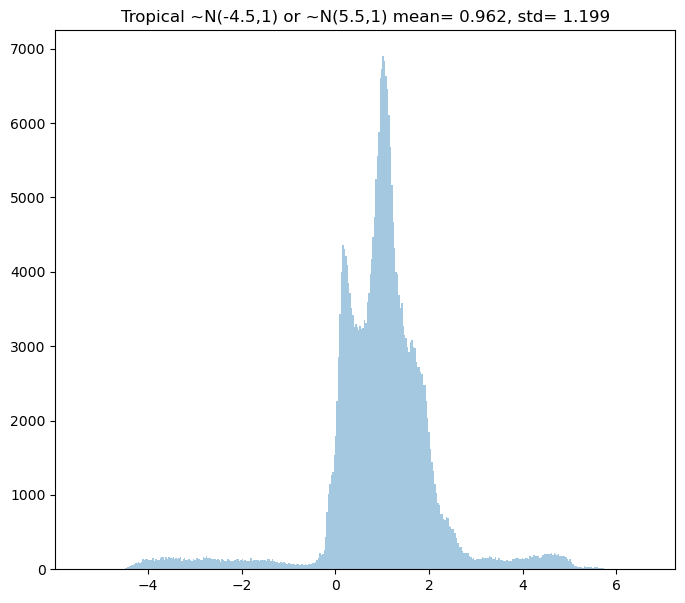

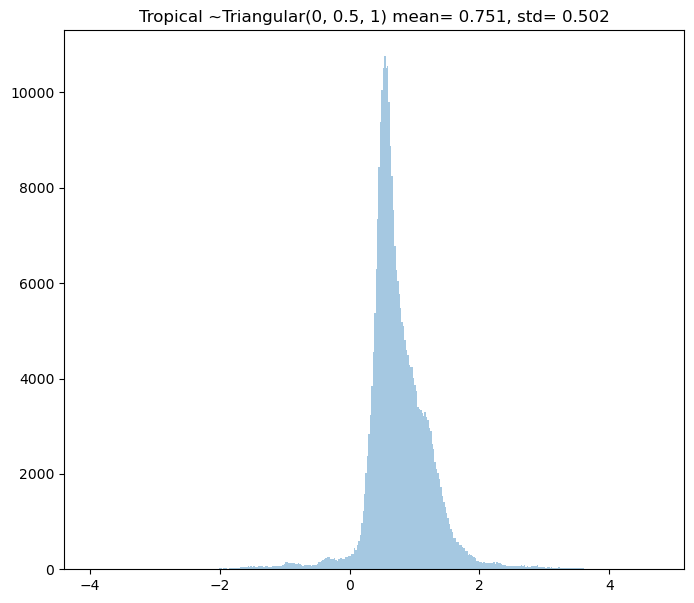

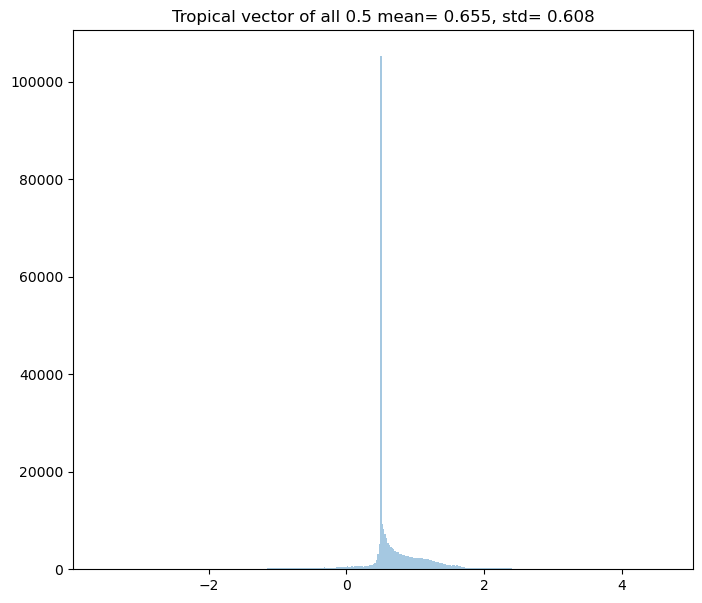

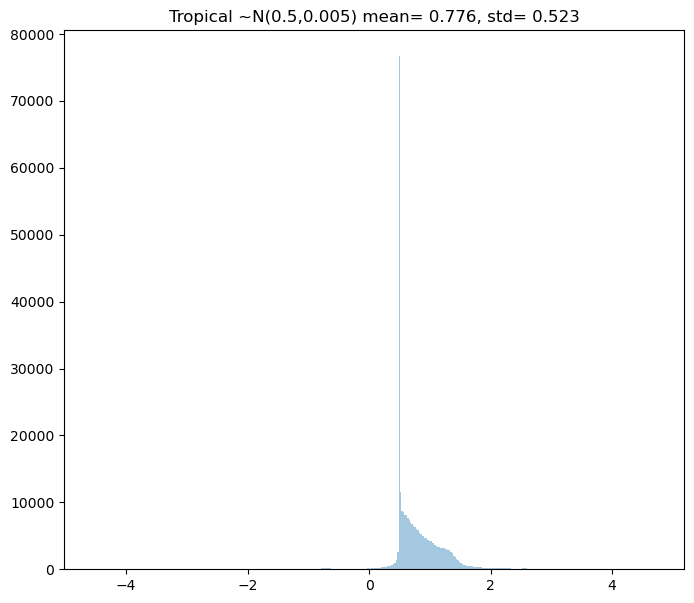

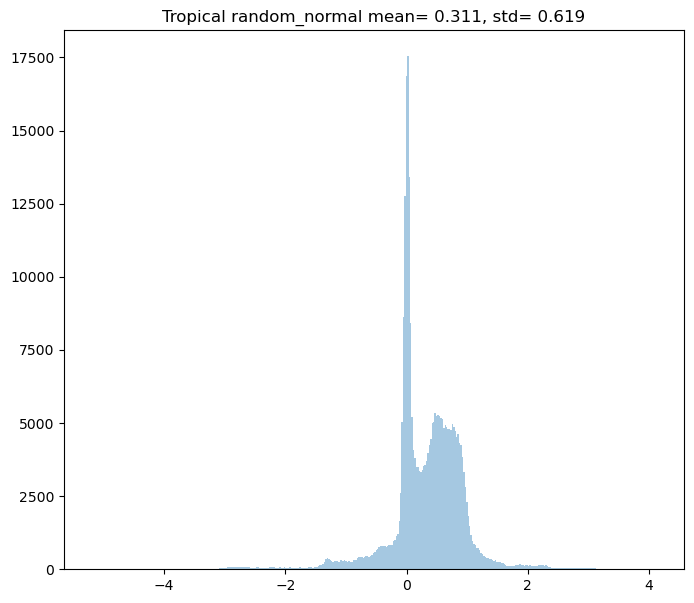

In [35]:
settings = [tup[2] for tup in tests]
for i in range(len(settings)):
    t1 = model_objects[i].layers[0].get_weights()[0].flatten()
    t1_m = np.mean(t1)
    t1_s = np.std(t1)
    plt.figure(figsize=(8,7))
    plt.hist(t1, alpha=0.4,  bins = 392)
    plt.title(f"{settings[i]} mean={t1_m: .3f}, std={t1_s: .3f}")
    plt.show()

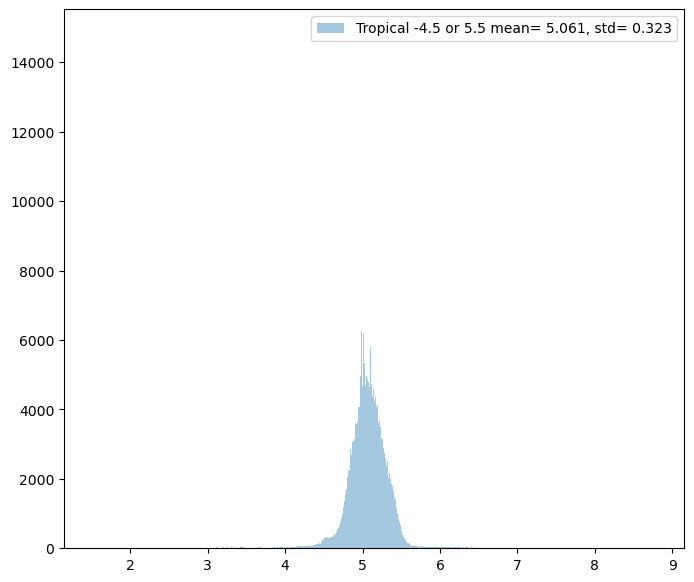

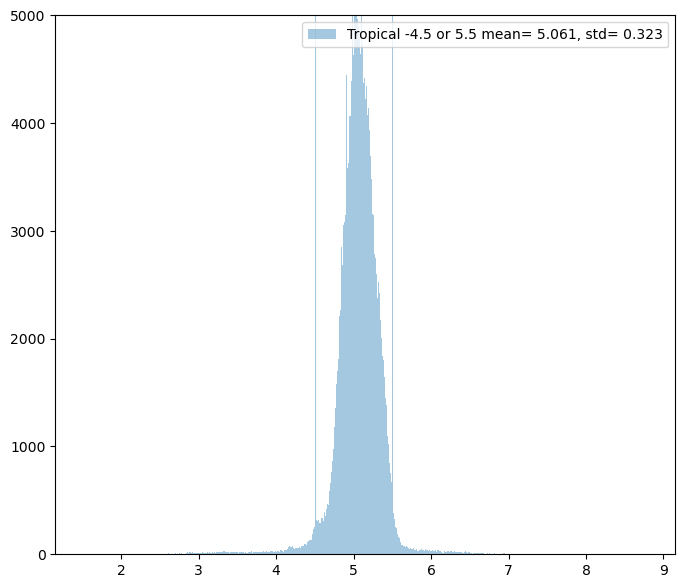

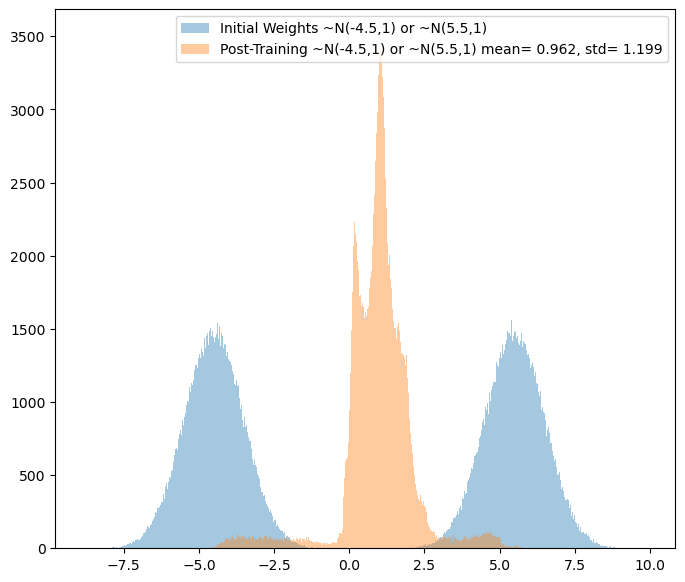

In [72]:
import tensorflow as tf
t1 = model_objects[1].layers[0].get_weights()[0].flatten()
t2 = model_objects[2].layers[0].get_weights()[0].flatten()

t1_m = np.mean(t1)
t1_s = np.std(t1)
t2_m = np.mean(t2)
t2_s = np.std(t2)

binnies = 784

plt.figure(figsize=(8,7))
plt.hist(t1, alpha=0.4, label=f"Tropical -4.5 or 5.5 mean={t1_m: .3f}, std={t1_s: .3f}",  bins = binnies)
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
plt.hist(t1, alpha=0.4, label=f"Tropical -4.5 or 5.5 mean={t1_m: .3f}, std={t1_s: .3f}",  bins = binnies)
plt.legend()
plt.ylim(0, 5000)
plt.show()

plt.figure(figsize=(8,7))
initializer = BimodalNormalInitializer(stddev=1,high=5.5, low=-4.5) 
weights_tensor = initializer(shape=(100, 3072), dtype=tf.float32)
plt.hist(weights_tensor.numpy().flatten(), alpha=0.4,bins=binnies, label='Initial Weights ~N(-4.5,1) or ~N(5.5,1)')
plt.hist(t2, alpha=0.4, label=f"Post-Training ~N(-4.5,1) or ~N(5.5,1) mean={t2_m: .3f}, std={t2_s: .3f}", bins = binnies)
plt.legend()
plt.show()


### MNIST, all numbers PGD test

In [85]:
iterations = 50
loss_object = losses.CategoricalCrossentropy()
x_train, x_test, y_train, y_test = load_MNIST_data(desired_classes=[i for i in range(10)])
#tests = [(buildReLuModel, initializers.RandomNormal(mean=0.5, stddev=1., seed=0), "ReLU"),
#         (buildTropicalModel, BimodalBinaryInitializer(high=4, low=-3), "Tropical -3 or 4"),
tests = [(buildTropicalModel, BimodalNormalInitializer(stddev=1,high=4, low=-3), "Tropical ~N(-3,1) or ~N(4,1)")]
#         (buildTropicalModel, initializers.RandomNormal(0.5, 0.005, seed=0), "Tropical ~N(0.5,0.005)")]

model_objects = []
for i in range(iterations):
    print(f'================\n\t{i}\n================')
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test) 
    data = []
    
    for model, intializer_w, name in tests:
        built_model = model(x_train, y_train, first_layer_size = 100, initializer_w=intializer_w, verbose = 1,
                            second_layer_size = 10,second_layer_activation = 'softmax', training_loss = 'categorical_crossentropy')
        #x_test_att = attackTestSetBatch(built_model, x_test, y_test, loss_object, name)
        #pre_loss, pre_acc = built_model.evaluate(x_test, y_test)
        #post_loss, post_acc = built_model.evaluate(x_test_att, y_test)
        #data.extend([pre_loss, pre_acc, post_loss, post_acc])
        model_objects.append(built_model)
    #with open('bimodalTest.csv', 'a', newline='') as csvfile:
        #csvwriter = csv.writer(csvfile)
        #csvwriter.writerow(data)

	0
Epoch 1/10
1875/1875 [==============================] - 25s 12ms/step - loss: 14.2955 - accuracy: 0.3801
Epoch 2/10
1875/1875 [==============================] - 20s 11ms/step - loss: 3.1338 - accuracy: 0.6123
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 3.7543 - accuracy: 0.6347
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 4.1042 - accuracy: 0.6446
Epoch 5/10
1875/1875 [==============================] - 31s 17ms/step - loss: 3.7811 - accuracy: 0.6772
Epoch 6/10
1875/1875 [==============================] - 40s 21ms/step - loss: 4.0361 - accuracy: 0.6739
Epoch 7/10
1875/1875 [==============================] - 40s 21ms/step - loss: 3.9616 - accuracy: 0.6867
Epoch 8/10
1875/1875 [==============================] - 40s 21ms/step - loss: 4.0786 - accuracy: 0.6885
Epoch 9/10
1875/1875 [==============================] - 40s 21ms/step - loss: 4.0865 - accuracy: 0.6894
Epoch 10/10
1875/1875 [==============================] - 40s

In [86]:
import os
import tensorflow as tf
save_dir = 'saved_models'  # Change this to your desired directory
os.makedirs(save_dir, exist_ok=True)
for i, model in enumerate(model_objects):
    model_name = f'model_{i}.h5'  # Adjust the naming scheme as needed
    model_path = os.path.join(save_dir, model_name)
    tf.keras.models.save_model(model, model_path)

NotImplementedError: 
Layer TropEmbedMaxMin has arguments ['units', 'input_dim', 'initializer_w']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

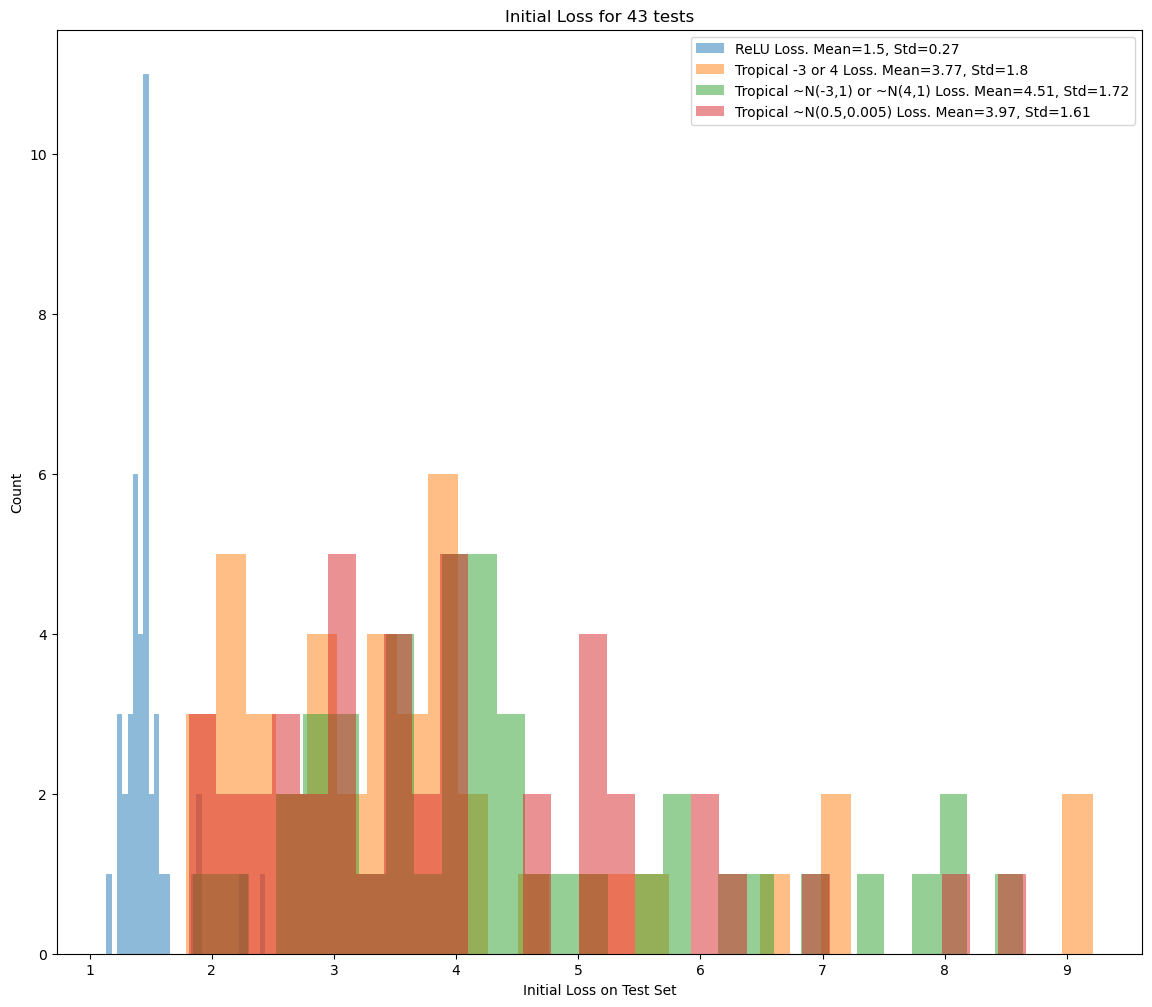

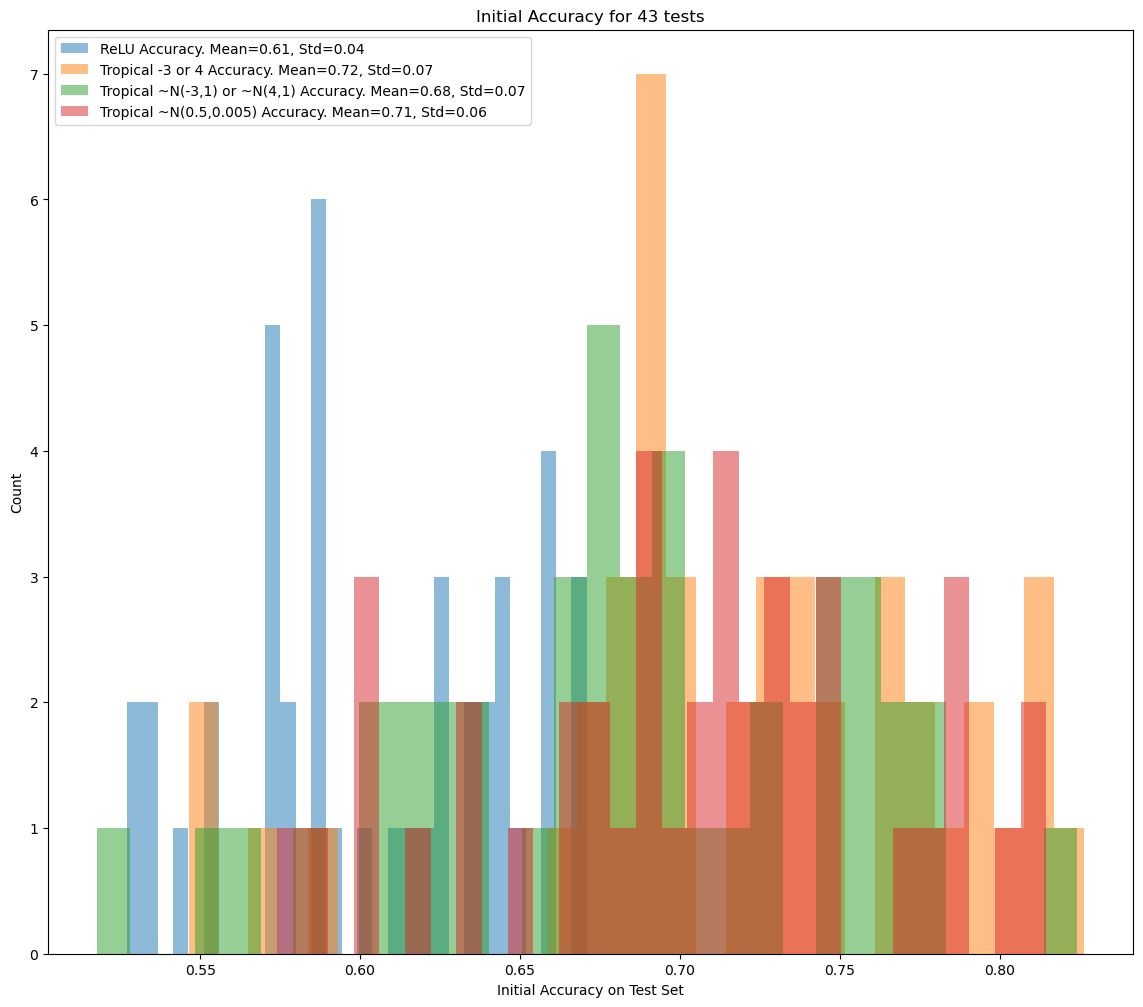

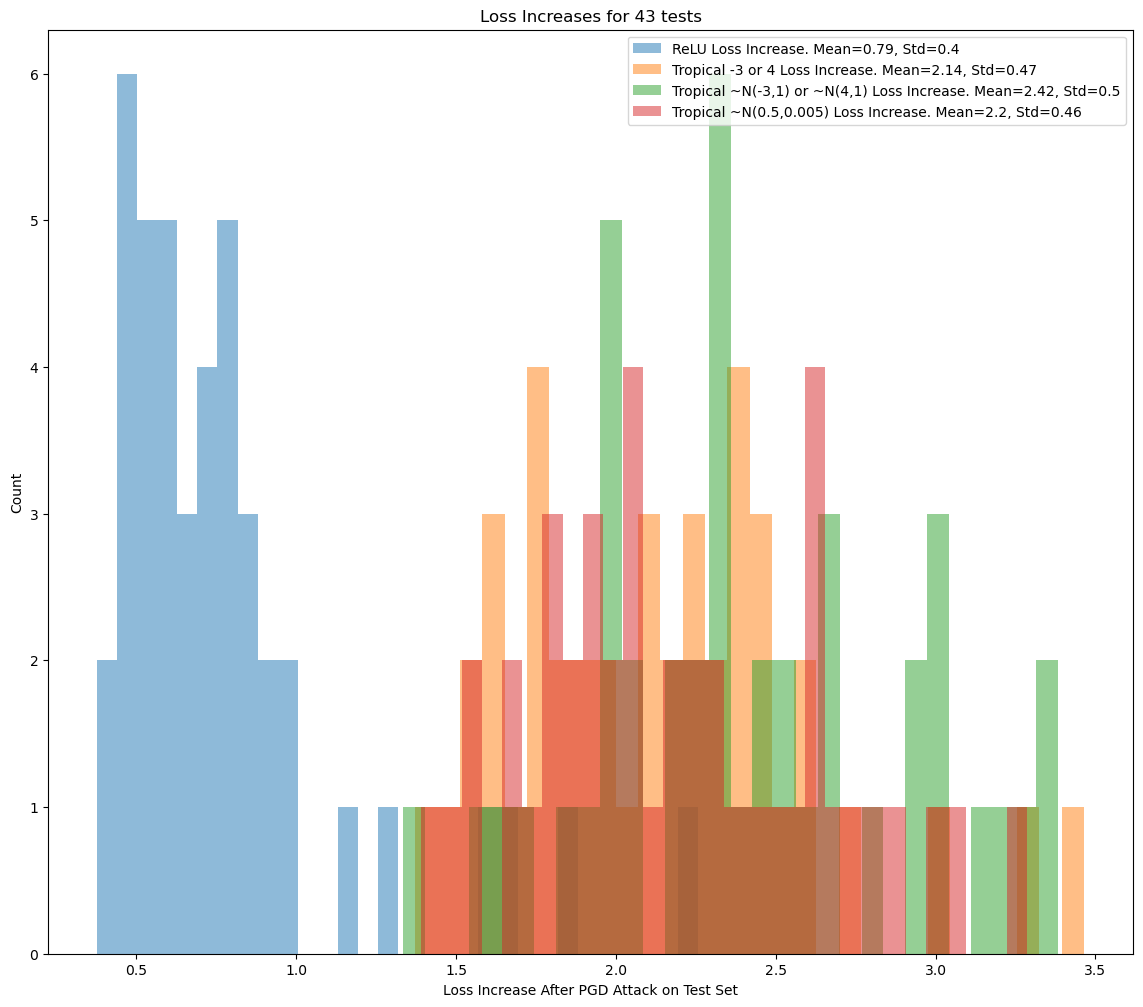

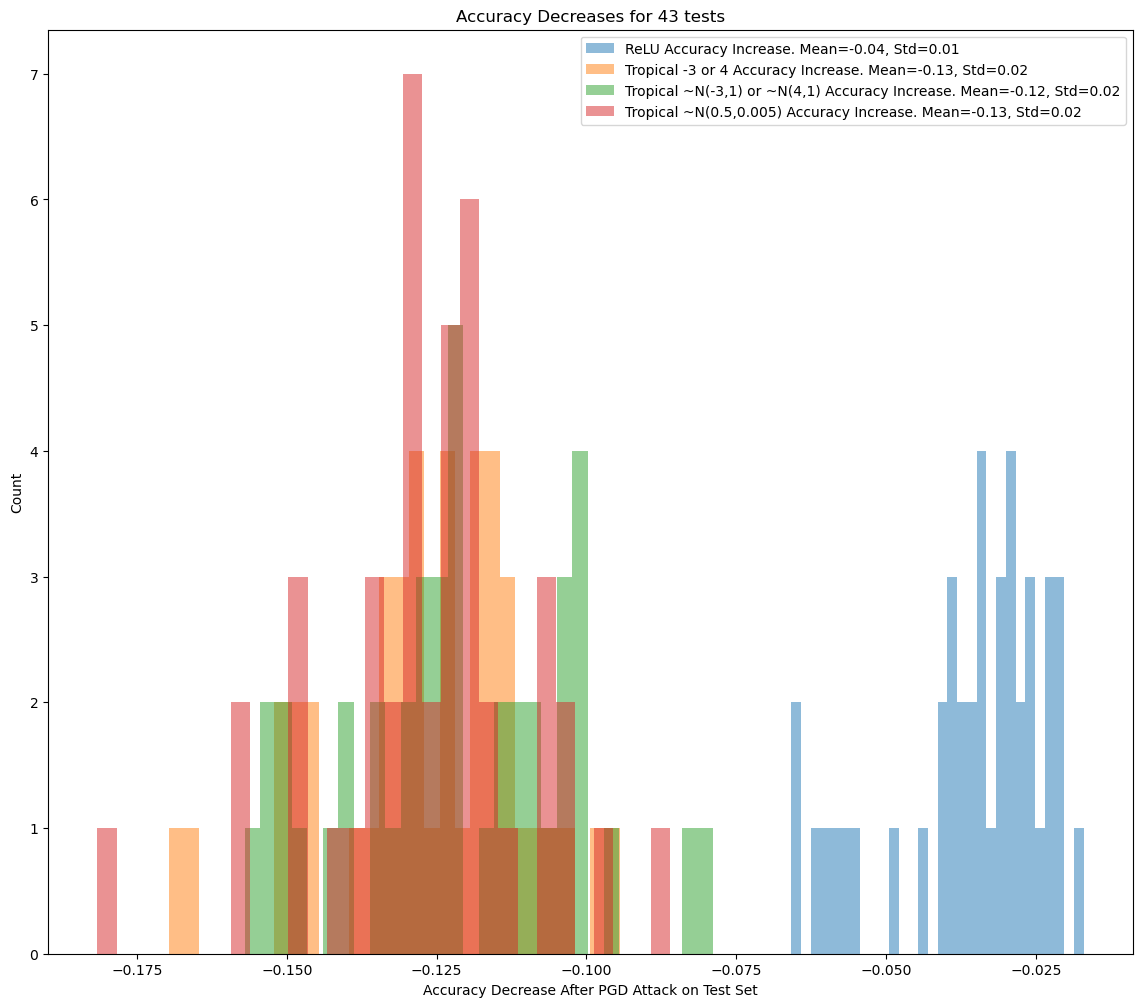

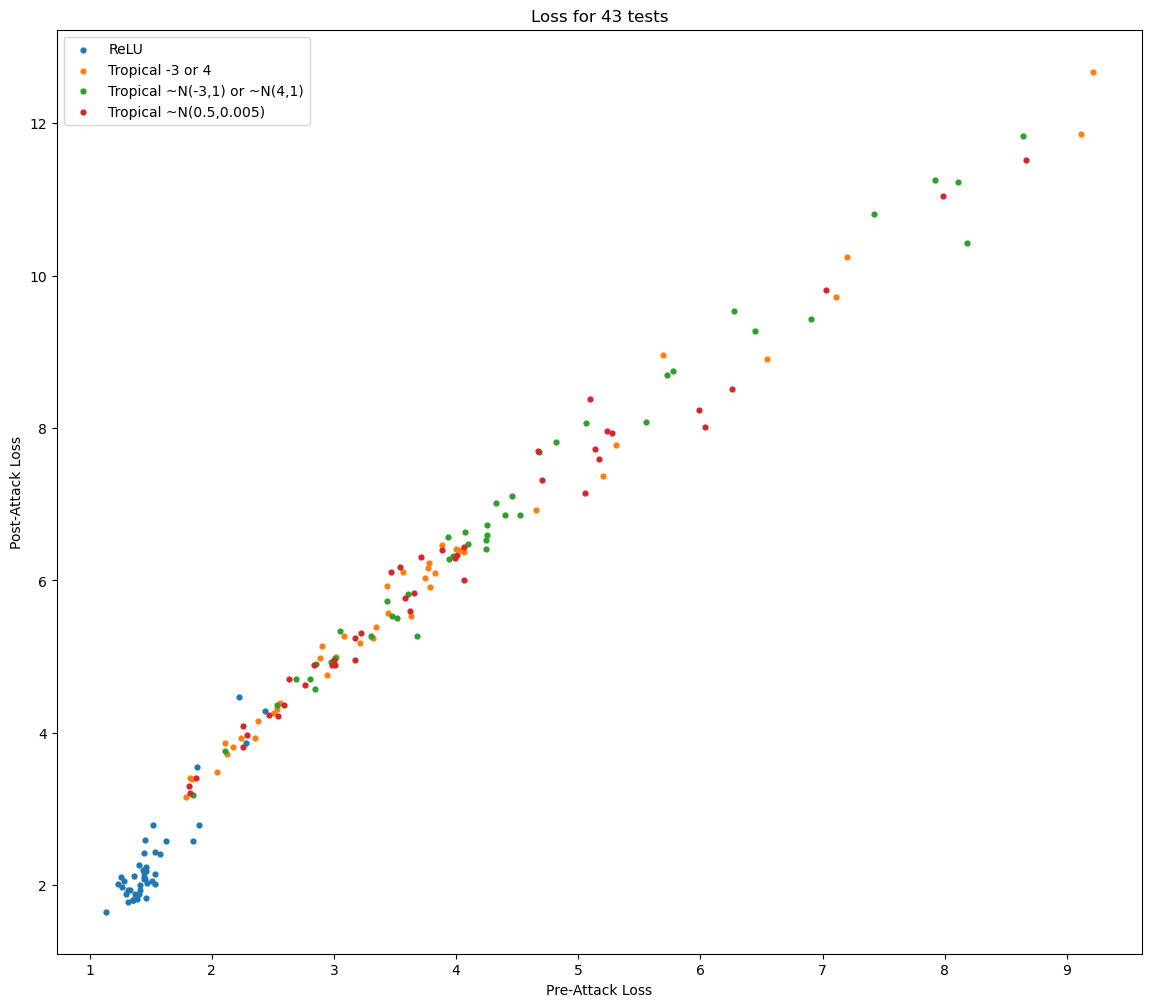

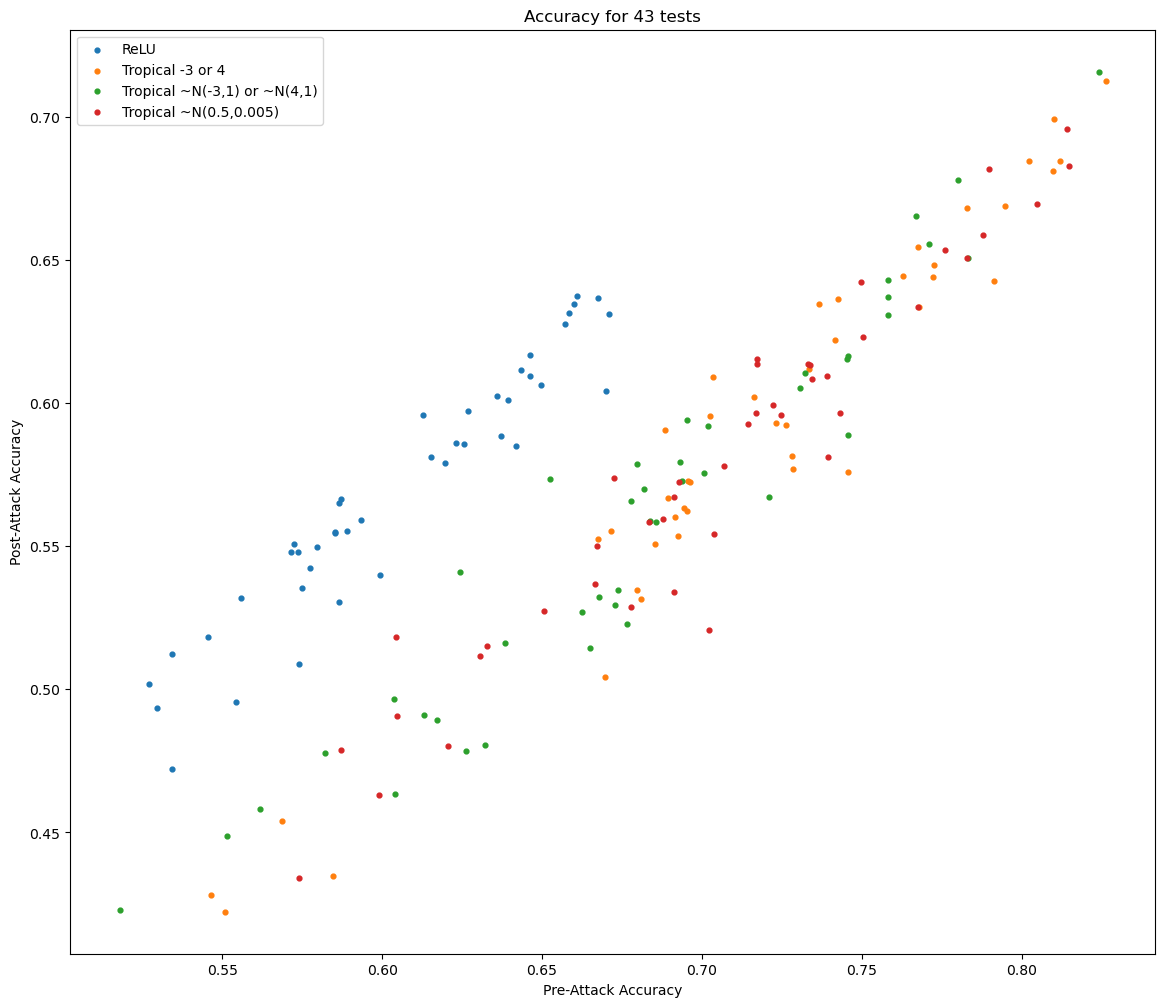

In [4]:
scat_size = 12
bin_num = 30
hist_wid = 14
hist_hei = 12
data = pd.read_csv("bimodalTest.csv")
rowNum = data.shape[0]

data["relu_loss_diff"] = data['relu_post_loss'] - data['relu_pre_loss']
data["relu_acc_diff"] = data['relu_post_acc'] - data['relu_pre_acc']

data["trop_loss_diff1"] = data['trop_post_loss1'] - data['trop_pre_loss1']
data["trop_acc_diff1"] = data['trop_post_acc1'] - data['trop_pre_acc1']

data["trop_loss_diff2"] = data['trop_post_loss2'] - data['trop_pre_loss2']
data["trop_acc_diff2"] = data['trop_post_acc2'] - data['trop_pre_acc2']

data["trop_loss_diff3"] = data['trop_post_loss3'] - data['trop_pre_loss3']
data["trop_acc_diff3"] = data['trop_post_acc3'] - data['trop_pre_acc3']

columns = ["relu_pre_loss", "trop_pre_loss1", "trop_pre_loss2", "trop_pre_loss3"]
settings = ["ReLU", "Tropical -3 or 4", "Tropical ~N(-3,1) or ~N(4,1)", "Tropical ~N(0.5,0.005)"]

plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.hist(np.array(data[columns[i]]), bins=bin_num, alpha=0.5, label=f'{settings[i]} Loss. Mean={round(data[columns[i]].mean(),2)}, Std={round(data[columns[i]].std(),2)}')
plt.xlabel('Initial Loss on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Loss for {rowNum} tests')
plt.legend()
plt.show()

columns = ["relu_pre_acc", "trop_pre_acc1", "trop_pre_acc2", "trop_pre_acc3"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.hist(np.array(data[columns[i]]), bins=bin_num, alpha=0.5, label=f'{settings[i]} Accuracy. Mean={round(data[columns[i]].mean(),2)}, Std={round(data[columns[i]].std(),2)}')
plt.xlabel('Initial Accuracy on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Accuracy for {rowNum} tests')
plt.legend()
plt.show()

columns = ["relu_loss_diff", "trop_loss_diff1", "trop_loss_diff2", "trop_loss_diff3"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.hist(np.array(data[columns[i]]), bins=bin_num, alpha=0.5, label=f'{settings[i]} Loss Increase. Mean={round(data[columns[i]].mean(),2)}, Std={round(data[columns[i]].std(),2)}')
plt.xlabel('Loss Increase After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Loss Increases for {rowNum} tests')
plt.legend()
plt.show()

columns = ["relu_acc_diff", "trop_acc_diff1", "trop_acc_diff2", "trop_acc_diff3"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.hist(np.array(data[columns[i]]), bins=bin_num, alpha=0.5, label=f'{settings[i]} Accuracy Increase. Mean={round(data[columns[i]].mean(),2)}, Std={round(data[columns[i]].std(),2)}')
plt.xlabel('Accuracy Decrease After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Accuracy Decreases for {rowNum} tests')
plt.legend()
plt.show()

columns1 = ["relu_pre_loss", "trop_pre_loss1", "trop_pre_loss2", "trop_pre_loss3"]
columns2 = ["relu_post_loss", "trop_post_loss1", "trop_post_loss2", "trop_post_loss3"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.scatter(data[columns1[i]], data[columns2[i]], s=scat_size, label=settings[i])
plt.xlabel('Pre-Attack Loss')
plt.ylabel('Post-Attack Loss')
plt.title(f'Loss for {rowNum} tests')
plt.legend()
plt.show()

columns1 = ["relu_pre_acc", "trop_pre_acc1", "trop_pre_acc2", "trop_pre_acc3"]
columns2 = ["relu_post_acc", "trop_post_acc1", "trop_post_acc2", "trop_post_acc3"]
plt.figure(figsize=(hist_wid,hist_hei))
for i in range(len(columns)):
    plt.scatter(data[columns1[i]], data[columns2[i]], s=scat_size, label=settings[i])
plt.xlabel('Pre-Attack Accuracy')
plt.ylabel('Post-Attack Accuracy')
plt.title(f'Accuracy for {rowNum} tests')
plt.legend()
plt.show()


In [42]:
normal_images = x_test.reshape(-1, 28, 28)
relu_images = relu_x_test_att.reshape(-1, 28, 28)
trop_images = trop_x_test_att1.reshape(-1, 28, 28)

def show_images(images, num_images=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i+5], cmap='gray')
        plt.axis('off')
    plt.show()

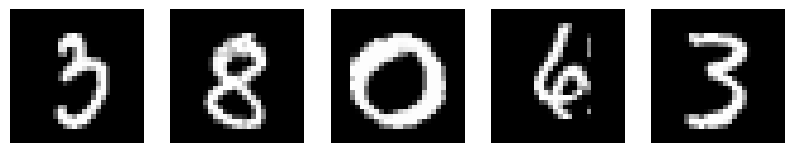

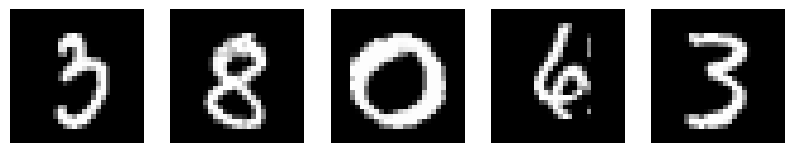

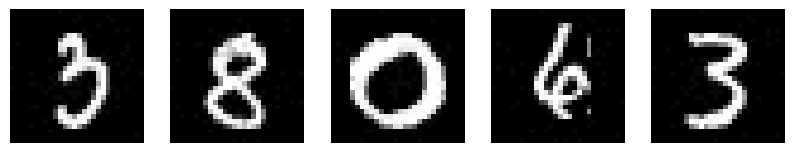

In [43]:
show_images(normal_images, num_images=5)
show_images(relu_images, num_images=5)
show_images(trop_images, num_images=5)

In [103]:
#model_predictions = [model_objects[i].predict(x_test) for i in range(len(model_objects))]
ensemble_sum = np.sum(model_predictions, axis=0)
true_class_indices = np.argmax(y_test, axis=1)
ensemble_class_indices = np.argmax(ensemble_sum, axis=1)
accuracy = np.mean(true_class_indices == ensemble_class_indices)
print(f'Ensemble Accuracy: {accuracy}')

Ensemble Accuracy: 0.886


In [84]:
for i in range(4):
    model_objects[i].evaluate(x_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 4.3212 - accuracy: 0.6553


(78400,)


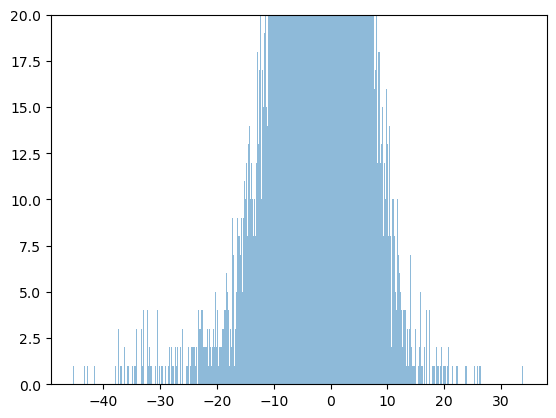

In [23]:
reluModel = model_objects[0]
weights = reluModel.layers[0].get_weights()[0].flatten()
biases = reluModel.layers[0].get_weights()[1].flatten()
print(weights.shape)
plt.hist(weights, bins=int(784), alpha=0.5)
#plt.hist(biases, bins=int(784), alpha=0.5)
plt.ylim(0, 20)
plt.show()

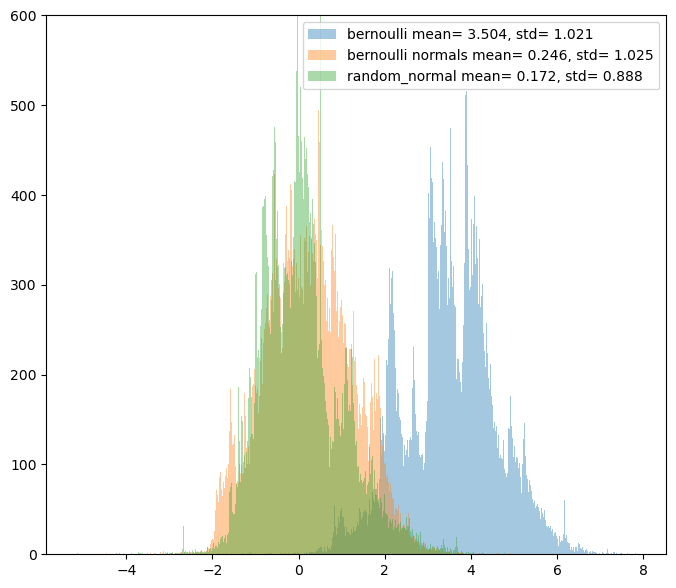

In [36]:
t1 = model_objects[1].layers[0].get_weights()[0].flatten()
t2 = model_objects[2].layers[0].get_weights()[0].flatten()
t3 = model_objects[3].layers[0].get_weights()[0].flatten()

t1_m = np.mean(t1)
t1_s = np.std(t1)
t2_m = np.mean(t2)
t2_s = np.std(t2)
t3_m = np.mean(t3)
t3_s = np.std(t3)

binnies = 784

plt.figure(figsize=(8,7))
plt.hist(t1, alpha=0.4, label=f"bernoulli mean={t1_m: .3f}, std={t1_s: .3f}",  bins = binnies)
plt.hist(t2, alpha=0.4, label=f"bernoulli normals mean={t2_m: .3f}, std={t2_s: .3f}", bins = binnies)
plt.hist(t3, alpha=0.4, label=f"random_normal mean={t3_m: .3f}, std={t3_s: .3f}", bins = binnies)
#plt.hist(weights, alpha=0.4, label="ReLU", density=True, bins = binnies)
plt.ylim(0, 600)
plt.legend()
plt.show()


In [3]:
import tensorflow as tf

NameError: name 't3' is not defined

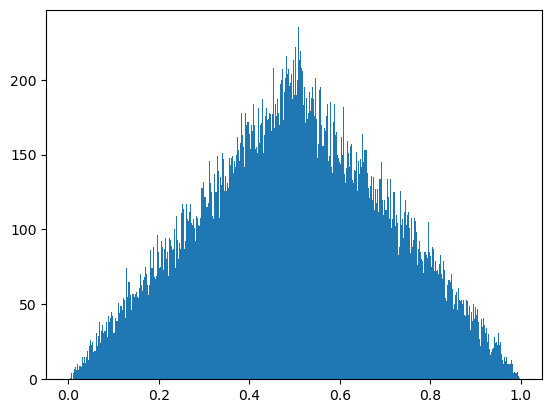

In [4]:
initializer = Triangular(left=0,mode=0.5, right=1)  # You can set the seed for reproducibility
weights_tensor = initializer(shape=(100, 784), dtype=tf.float32)
plt.hist(weights_tensor.numpy().flatten(), bins=784)
plt.hist(t3, bins=784, alpha=0.4, label=f"random_normal {round(np.mean(t3),3)}, {np.sum(t3 < 0)}, {np.sum(t3 > 0)}")
plt.ylim(0, 600)
plt.show()

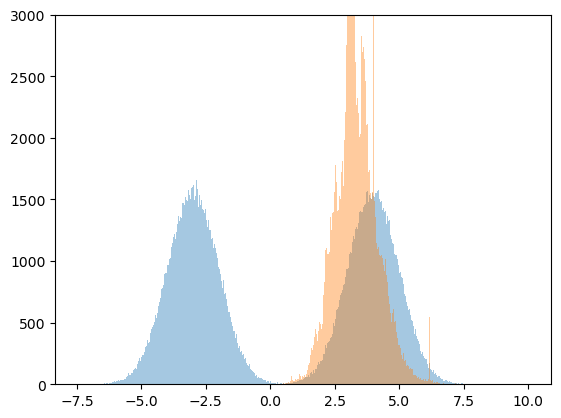

In [39]:
initializer = BimodalNormalInitializer(high=4, low=-3, seed=42)  # You can set the seed for reproducibility
weights_tensor = initializer(shape=(500, 784), dtype=tf.float32)
#weights_tensor.numpy()
plt.hist(weights_tensor.numpy().flatten(), bins = 784,alpha =0.4)
plt.hist(built_model.layers[0].get_weights()[0].flatten(), bins=int(784), alpha=0.4)
plt.ylim(0, 3000)
plt.show()

### PGD Experiment

In [ ]:
iterations = 500 #aribitrary
loss_object = losses.BinaryCrossentropy()
x_train, x_test, y_train, y_test = load_MNIST_data(desired_classes=[2, 8])

for i in range(iterations):
    print(f'================\n\t{i}\n================')
    x_train, x_test, y_train, y_test = shuffle_data(x_train, x_test, y_train, y_test) 

    reluModel = buildReLuModel(x_train, y_train, verbose=1)
    #relu_x_test_att = attackTestSet(reluModel, x_test, y_test, loss_object, "ReLu")
    relu_pre_loss, relu_pre_acc = reluModel.evaluate(x_test, y_test)
    #relu_post_loss, relu_post_acc = reluModel.evaluate(relu_x_test_att, y_test)

    tropModel1 = buildTropicalModel(x_train, y_train, verbose=1)
    #trop_x_test_att1 = attackTestSet(tropModel1, x_test, y_test, loss_object, "Tropical")
    trop_pre_loss1, trop_pre_acc1 = tropModel1.evaluate(x_test, y_test)
    #trop_post_loss1, trop_post_acc1 = tropModel1.evaluate(trop_x_test_att1, y_test)

    # - write to csv - 
    data = [relu_pre_loss, relu_pre_acc, relu_post_loss, relu_post_acc,trop_pre_loss1, trop_pre_acc1, trop_post_loss1, trop_post_acc1]
    with open('output4.csv', 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

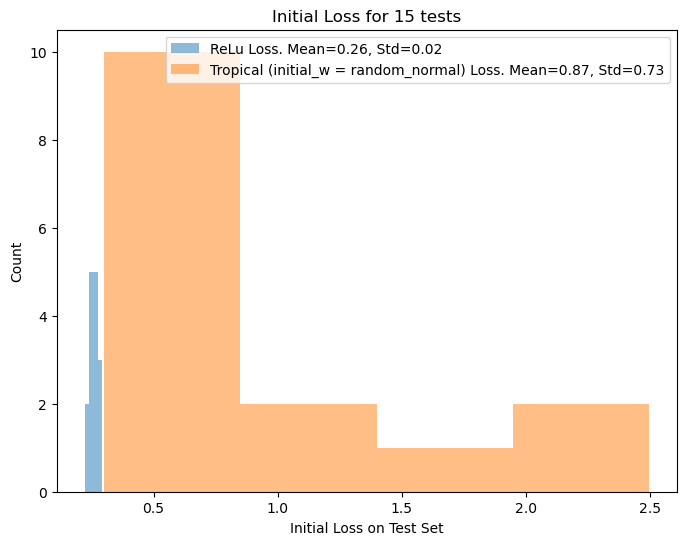

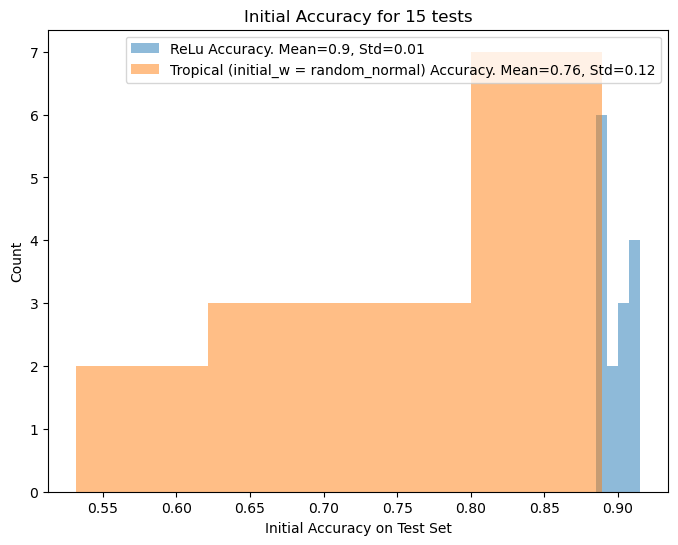

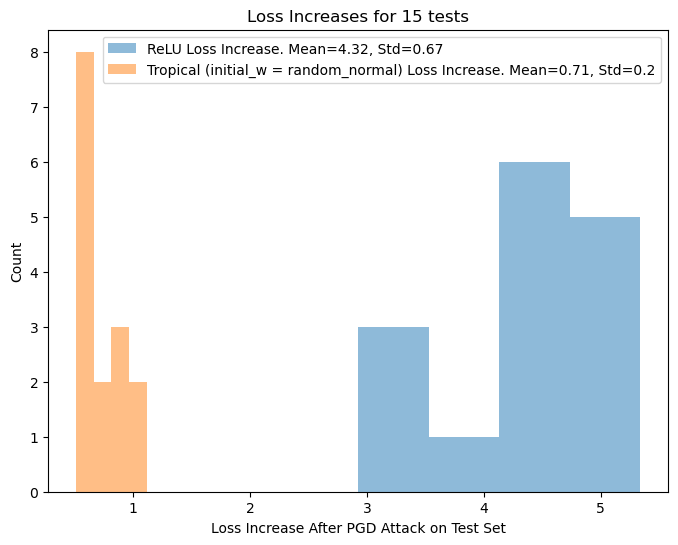

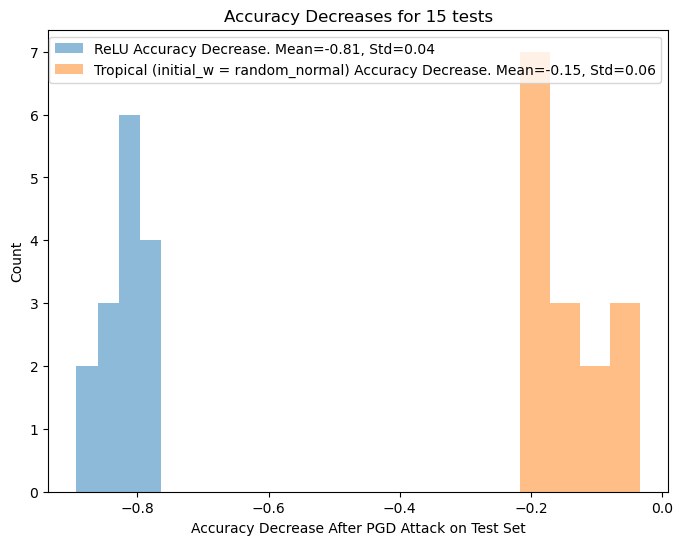

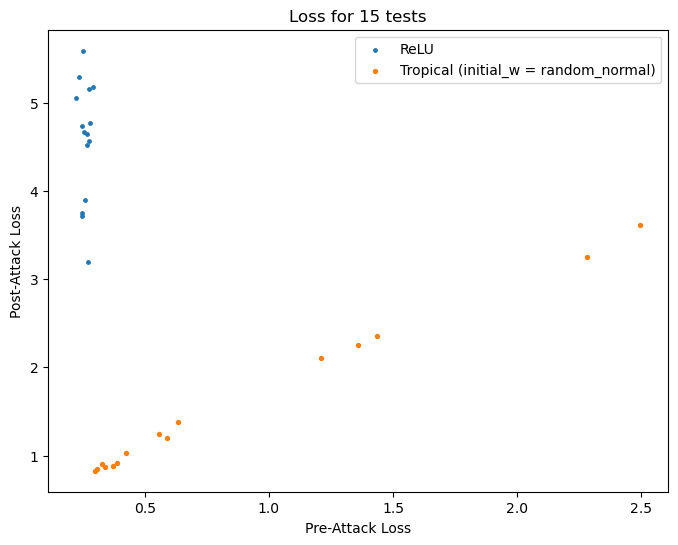

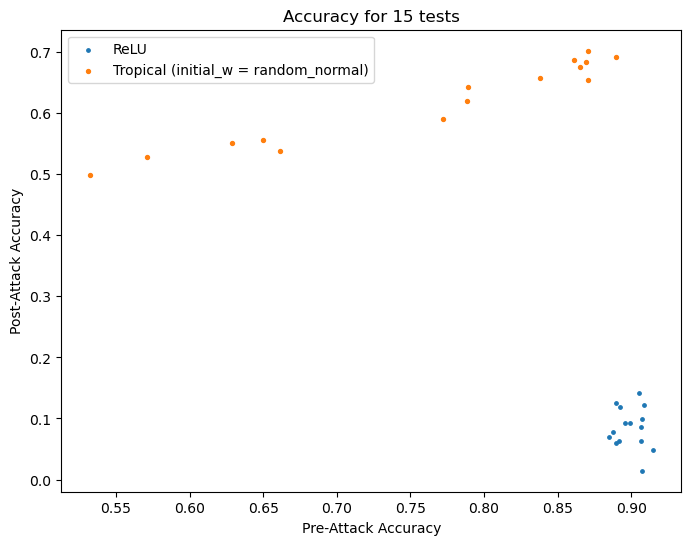

In [3]:
scat_size = 8
bin_num = 4
hist_wid = 8
hist_hei = 6
data = pd.read_csv("output3.csv")
rowNum = data.shape[0]

data["relu_loss_diff"] = data['relu_post_loss'] - data['relu_pre_loss']
data["trop_loss_diff1"] = data['trop_post_loss1'] - data['trop_pre_loss1']
data["relu_acc_diff"] = data['relu_post_acc'] - data['relu_pre_acc']
data["trop_acc_diff1"] = data['trop_post_acc1'] - data['trop_pre_acc1']


plt.figure(figsize=(hist_wid,hist_hei))
plt.hist(np.array(data["relu_pre_loss"]), bins=bin_num, alpha=0.5, label=f'ReLu Loss. Mean={round(data["relu_pre_loss"].mean(),2)}, Std={round(data["relu_pre_loss"].std(),2)}')
plt.hist(np.array(data["trop_pre_loss1"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = random_normal) Loss. Mean={round(data["trop_pre_loss1"].mean(),2)}, Std={round(data["trop_pre_loss1"].std(),2)}')
plt.xlabel('Initial Loss on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Loss for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.hist(np.array(data["relu_pre_acc"]), bins=bin_num, alpha=0.5, label=f'ReLu Accuracy. Mean={round(data["relu_pre_acc"].mean(),2)}, Std={round(data["relu_pre_acc"].std(),2)}')
plt.hist(np.array(data["trop_pre_acc1"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = random_normal) Accuracy. Mean={round(data["trop_pre_acc1"].mean(),2)}, Std={round(data["trop_pre_acc1"].std(),2)}')
plt.xlabel('Initial Accuracy on Test Set')
plt.ylabel('Count')
plt.title(f'Initial Accuracy for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.hist(np.array(data["relu_loss_diff"]), bins=bin_num, alpha=0.5, label=f'ReLU Loss Increase. Mean={round(data["relu_loss_diff"].mean(),2)}, Std={round(data["relu_loss_diff"].std(),2)}')
plt.hist(np.array(data["trop_loss_diff1"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = random_normal) Loss Increase. Mean={round(data["trop_loss_diff1"].mean(),2)}, Std={round(data["trop_loss_diff1"].std(),2)}')
plt.xlabel('Loss Increase After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Loss Increases for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.hist(np.array(data["relu_acc_diff"]), bins=bin_num, alpha=0.5, label=f'ReLU Accuracy Decrease. Mean={round(data["relu_acc_diff"].mean(),2)}, Std={round(data["relu_acc_diff"].std(),2)}')
plt.hist(np.array(data["trop_acc_diff1"]), bins=bin_num, alpha=0.5, label=f'Tropical (initial_w = random_normal) Accuracy Decrease. Mean={round(data["trop_acc_diff1"].mean(),2)}, Std={round(data["trop_acc_diff1"].std(),2)}')
plt.xlabel('Accuracy Decrease After PGD Attack on Test Set')
plt.ylabel('Count')
plt.title(f'Accuracy Decreases for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.scatter(data['relu_pre_loss'], data['relu_post_loss'], s=6, label=f'ReLU')
plt.scatter(data['trop_pre_loss1'], data['trop_post_loss1'], s=scat_size, label=f'Tropical (initial_w = random_normal)')
plt.xlabel('Pre-Attack Loss')
plt.ylabel('Post-Attack Loss')
plt.title(f'Loss for {rowNum} tests')
plt.legend()
plt.show()

plt.figure(figsize=(hist_wid,hist_hei))
plt.scatter(data['relu_pre_acc'], data['relu_post_acc'], s=6, label=f'ReLU')
plt.scatter(data['trop_pre_acc1'], data['trop_post_acc1'], s=scat_size, label=f'Tropical (initial_w = random_normal)')
plt.xlabel('Pre-Attack Accuracy')
plt.ylabel('Post-Attack Accuracy')
plt.title(f'Accuracy for {rowNum} tests')
plt.legend()
plt.show()
